# CloFormer

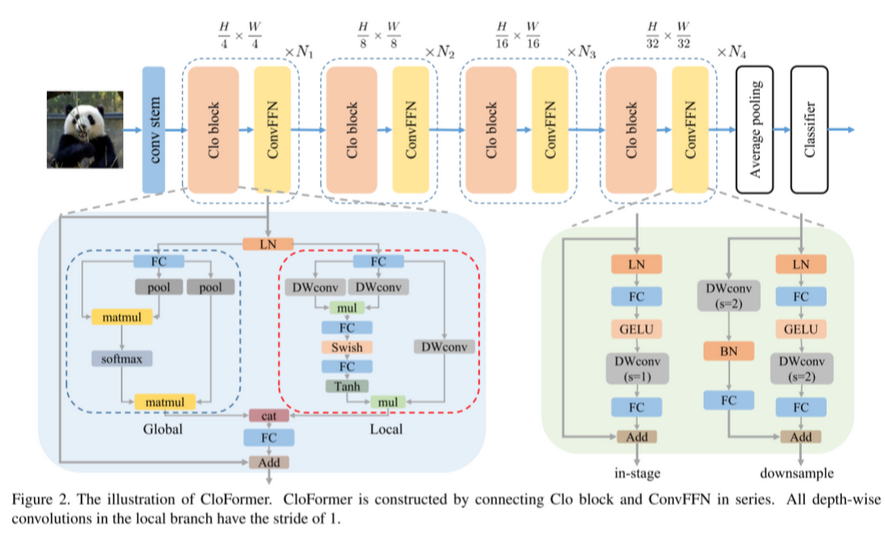

## 1. Clo Block

每个 Clo 块由一个局部分支和一个全局分支组成。  
1.1 全局分支。全局分支使用传统的注意力机制，但对 K 和 V 进行了下采样以减少计算量，从而捕捉低频全局信息。具体公式如下：

    

1.2 局部分支（AttnConv）。在局部分支中，本文引入了一个精心设计的 AttnConv，一种简单而有效的卷积操作符，它采用了注意力机制的风格。所提出的 AttnConv 有效地融合了共享权重和上下文感知权重，以聚合高频的局部信息。具体地，AttnConv 首先使用深度卷积（DWconv）提取局部表示，其中 DWconv 具有共享权重。然后，其使用上下文感知权重来增强局部特征。与 Non-Local 等生成上下文感知权重的方法不同，AttnConv 使用门控机制生成上下文感知权重，引入了比常用的注意力机制更强的非线性。此外，AttnConv 将卷积算子应用于 Query 和 Key 以聚合局部信息，然后计算 Q 和 K 的哈达玛积，并对结果进行一系列线性或非线性变换，生成范围在 [-1,1] 之间的上下文感知权重。值得注意的是，AttnConv 继承了卷积的平移等变性，因为它的所有操作都基于卷积。具体公式如下：

    Q,K,V=FC(Xin)
    Vs=DWconv(V)
    Ql=DWconv(Q)
    Kl=DWconv(K)
    Attnt=FC(Swish(FC(Ql⊙Kl)))
    Attn=Tanh(Attnt / √d)
    Xlocal =Attn⊙Vs

最后，将全局特征和局部特征合并起来，并使用一个MLP得到最终的输出。公式表示如下：

    Xt=Concat(Xlocal ,Xglobal )
    Xout =FC(Xt)

### AttnConv

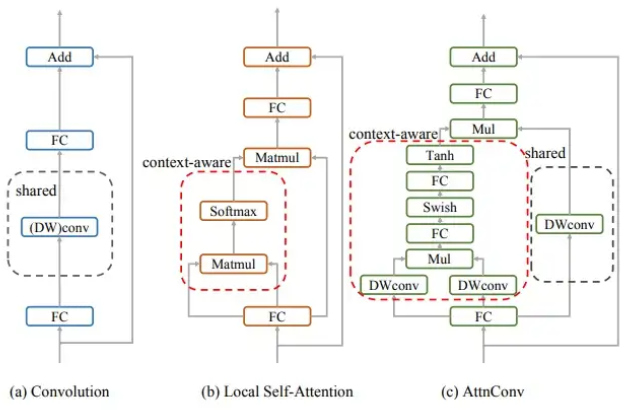

### Swish

Swish is an activation function that has recently been used in deep learning models, including MobileNetV3 and EfficientNets. Mathematically, Swish function is defined as:

Swish(x)=x Sigmoid(x)

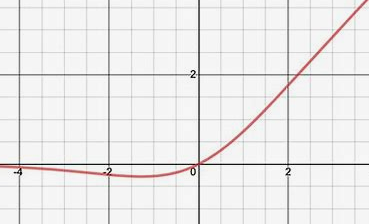

### LN

BN并不适用于RNN等动态网络和batch size较小的情况。Layer Normalization（LN）的提出有效的解决BN的这两个问题。LN和BN不同点是归一化的维度是互相垂直的

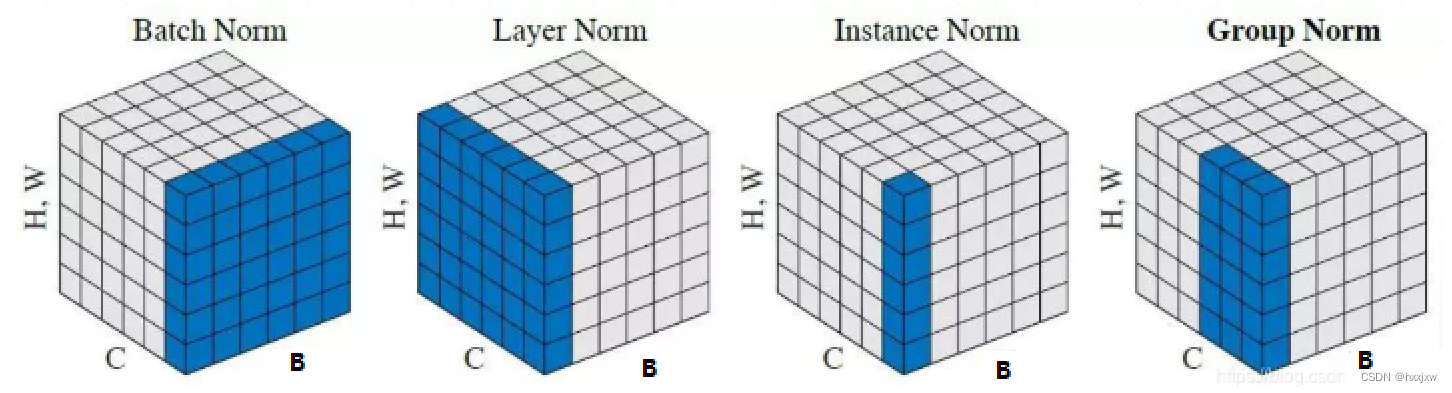

## 2. ConvFFN

为了将局部信息融入 FFN（feed-forward network, i.e., MLP） 过程中，采用 ConvFFN 替换了常用的 FFN。ConvFFN 和常用的 FFN 的主要区别在于，ConvFFN 在 GELU 激活函数之后使用了深度卷积（DWconv），从而使 ConvFFN 能够聚合局部信息。由于DWconv 的存在，可以直接在 ConvFFN 中进行下采样而不需要引入 Patch Merge 模块。CloFormer 使用了两种ConvFFN。第一种是在阶段内的 ConvFFN，它直接利用跳跃连接。另一种是连接两个阶段的 ConvFFN，主要用于下采样操作。

# Example

https://github.com/qhfan/CloFormer

In [21]:
import torch
import torch.nn as nn
from typing import List
import torch.utils.checkpoint as checkpoint
import torch.nn.functional as F
from timm.models.layers import DropPath
from efficientnet_pytorch.model import MemoryEfficientSwish

class BasicBlock(nn.Module):    
    '''
    A basic conv block
    '''
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size, stride, kernel_size//2), # kernel_size//2 is padding
                        nn.SyncBatchNorm(out_channels), # 用于分布式多GPU，同步norm统计量
                        nn.ReLU()
                    )
    
    def forward(self, x: torch.Tensor):
        return self.conv(x)


class DeepConv(nn.Module):
    '''
    定义包含5层conv的module
    '''

    def __init__(self, in_channels=3, out_channels=96):
        super().__init__()
        self.conv1 = BasicBlock(in_channels, out_channels//2, 3, 2)
        self.conv2 = BasicBlock(out_channels//2, out_channels, 3, 2)
        self.conv3 = BasicBlock(out_channels, out_channels, 3, 1)
        self.conv4 = BasicBlock(out_channels, out_channels, 3, 1)
        self.conv5 = nn.Conv2d(out_channels, out_channels, 1, 1, 0)
        self.layernorm = nn.GroupNorm(1, out_channels)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.layernorm(x)
        
class AttnMap(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.act_block = nn.Sequential(
                            nn.Conv2d(dim, dim, 1, 1, 0),
                            MemoryEfficientSwish(), # swish = x * sigmoid(x)
                            nn.Conv2d(dim, dim, 1, 1, 0)
                            #nn.Identity()
                         )
    def forward(self, x):
        return self.act_block(x)

class EfficientAttention(nn.Module):

    def __init__(self, dim, num_heads, group_split: List[int], kernel_sizes: List[int], window_size=7, 
                 attn_drop=0., proj_drop=0., qkv_bias=True):
        super().__init__()
        assert sum(group_split) == num_heads
        assert len(kernel_sizes) + 1 == len(group_split)
        self.dim = dim
        self.num_heads = num_heads
        self.dim_head = dim // num_heads
        self.scalor = self.dim_head ** -0.5
        self.kernel_sizes = kernel_sizes
        self.window_size = window_size
        self.group_split = group_split
        convs = []
        act_blocks = []
        qkvs = []
        #projs = []
        for i in range(len(kernel_sizes)):
            kernel_size = kernel_sizes[i]
            group_head = group_split[i]
            if group_head == 0:
                continue
            convs.append(nn.Conv2d(3*self.dim_head*group_head, 3*self.dim_head*group_head, kernel_size,
                         1, kernel_size//2, groups=3*self.dim_head*group_head))
            act_blocks.append(AttnMap(self.dim_head*group_head))
            qkvs.append(nn.Conv2d(dim, 3*group_head*self.dim_head, 1, 1, 0, bias=qkv_bias))
            #projs.append(nn.Linear(group_head*self.dim_head, group_head*self.dim_head, bias=qkv_bias))
        if group_split[-1] != 0:
            self.global_q = nn.Conv2d(dim, group_split[-1]*self.dim_head, 1, 1, 0, bias=qkv_bias)
            self.global_kv = nn.Conv2d(dim, group_split[-1]*self.dim_head*2, 1, 1, 0, bias=qkv_bias)
            #self.global_proj = nn.Linear(group_split[-1]*self.dim_head, group_split[-1]*self.dim_head, bias=qkv_bias)
            self.avgpool = nn.AvgPool2d(window_size, window_size) if window_size!=1 else nn.Identity()

        self.convs = nn.ModuleList(convs)
        self.act_blocks = nn.ModuleList(act_blocks)
        self.qkvs = nn.ModuleList(qkvs)
        self.proj = nn.Conv2d(dim, dim, 1, 1, 0, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

    def high_fre_attntion(self, x: torch.Tensor, to_qkv: nn.Module, mixer: nn.Module, attn_block: nn.Module):
        '''
        x: (b c h w)
        '''
        b, c, h, w = x.size()
        qkv = to_qkv(x) #(b (3 m d) h w)
        qkv = mixer(qkv).reshape(b, 3, -1, h, w).transpose(0, 1).contiguous() #(3 b (m d) h w)
        q, k, v = qkv #(b (m d) h w)
        attn = attn_block(q.mul(k)).mul(self.scalor)
        attn = self.attn_drop(torch.tanh(attn))
        res = attn.mul(v) #(b (m d) h w)
        return res
        
    def low_fre_attention(self, x : torch.Tensor, to_q: nn.Module, to_kv: nn.Module, avgpool: nn.Module):
        '''
        x: (b c h w)
        '''
        b, c, h, w = x.size()
        
        q = to_q(x).reshape(b, -1, self.dim_head, h*w).transpose(-1, -2).contiguous() #(b m (h w) d)
        kv = avgpool(x) #(b c h w)
        kv = to_kv(kv).view(b, 2, -1, self.dim_head, (h*w)//(self.window_size**2)).permute(1, 0, 2, 4, 3).contiguous() #(2 b m (H W) d)
        k, v = kv #(b m (H W) d)
        attn = self.scalor * q @ k.transpose(-1, -2) #(b m (h w) (H W))
        attn = self.attn_drop(attn.softmax(dim=-1))
        res = attn @ v #(b m (h w) d)
        res = res.transpose(2, 3).reshape(b, -1, h, w).contiguous()
        return res

    def forward(self, x: torch.Tensor):
        '''
        x: (b c h w)
        '''
        res = []
        for i in range(len(self.kernel_sizes)):
            if self.group_split[i] == 0:
                continue
            res.append(self.high_fre_attntion(x, self.qkvs[i], self.convs[i], self.act_blocks[i]))
        if self.group_split[-1] != 0:
            res.append(self.low_fre_attention(x, self.global_q, self.global_kv, self.avgpool))
        return self.proj_drop(self.proj(torch.cat(res, dim=1)))

class ConvFFN(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, stride,
                 out_channels, act_layer=nn.GELU, drop_out=0.):
        super().__init__()
        self.fc1 = nn.Conv2d(in_channels, hidden_channels, 1, 1, 0)
        self.act = act_layer()
        # depth-wise conv: When groups == in_channels and out_channels == K * in_channels, where K is a positive integer, this operation is also known as a “depthwise convolution”.
        self.dwconv = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, stride, 
                                kernel_size//2, groups=hidden_channels)
        self.fc2 = nn.Conv2d(hidden_channels, out_channels, 1, 1, 0)
        self.drop = nn.Dropout(drop_out)

    def forward(self, x: torch.Tensor):
        '''
        x: (b h w c)
        '''
        x = self.fc1(x)
        x = self.act(x)
        x = self.dwconv(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class EfficientBlock(nn.Module):

    def __init__(self, dim, out_dim, num_heads, group_split: List[int], kernel_sizes: List[int], window_size: int,
                 mlp_kernel_size: int, mlp_ratio: int, stride: int, attn_drop=0., mlp_drop=0., qkv_bias=True,
                 drop_path=0.):
        super().__init__()
        self.dim = dim
        self.mlp_ratio = mlp_ratio
        self.norm1 = nn.GroupNorm(1, dim)
        self.attn = EfficientAttention(dim, num_heads, group_split, kernel_sizes, window_size,
                                       attn_drop, mlp_drop, qkv_bias)
        self.drop_path = DropPath(drop_path)
        self.norm2 = nn.GroupNorm(1, dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.stride = stride
        if stride == 1:
            self.downsample = nn.Identity()
        else:
            self.downsample = nn.Sequential(
                                nn.Conv2d(dim, dim, mlp_kernel_size, 2, mlp_kernel_size//2),
                                nn.SyncBatchNorm(dim),
                                nn.Conv2d(dim, out_dim, 1, 1, 0),
                            )
        self.mlp = ConvFFN(dim, mlp_hidden_dim, mlp_kernel_size, stride, out_dim, 
                        drop_out=mlp_drop)
    def forward(self, x: torch.Tensor):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = self.downsample(x) + self.drop_path(self.mlp(self.norm2(x)))
        return x
        
class CloLayer(nn.Module):

    def __init__(self, depth, dim, out_dim, num_heads, group_split: List[int], kernel_sizes: List[int],
                 window_size: int, mlp_kernel_size: int, mlp_ratio: int, attn_drop=0,
                 mlp_drop=0., qkv_bias=True, drop_paths=[0., 0.], downsample=True, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList(
                        [
                            EfficientBlock(dim, dim, num_heads, group_split, kernel_sizes, window_size,
                                mlp_kernel_size, mlp_ratio, 1, attn_drop, mlp_drop, qkv_bias, drop_paths[i])
                                for i in range(depth-1)
                        ]
                    )
        if downsample is True:
            self.blocks.append(EfficientBlock(dim, out_dim, num_heads, group_split, kernel_sizes, window_size,
                            mlp_kernel_size, mlp_ratio, 2, attn_drop, mlp_drop, qkv_bias, drop_paths[-1]))
        else:
            self.blocks.append(EfficientBlock(dim, out_dim, num_heads, group_split, kernel_sizes, window_size,
                            mlp_kernel_size, mlp_ratio, 1, attn_drop, mlp_drop, qkv_bias, drop_paths[-1]))

    def forward(self, x: torch.Tensor):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        return x

class CloFormer(nn.Module):

    def __init__(self, in_chans, num_classes, embed_dims: List[int], depths: List[int],
                 num_heads: List[int], group_splits: List[List[int]], kernel_sizes: List[List[int]],
                 window_sizes: List[int], mlp_kernel_sizes: List[int], mlp_ratios: List[int],
                 attn_drop=0., mlp_drop=0., qkv_bias=True, drop_path_rate=0.1, use_checkpoint=False):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.mlp_ratios = mlp_ratios
        self.deep_conv = DeepConv(in_chans, embed_dims[0])

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            if i_layer != self.num_layers-1:
                layer = CloLayer(depths[i_layer], embed_dims[i_layer], embed_dims[i_layer+1], num_heads[i_layer],
                            group_splits[i_layer], kernel_sizes[i_layer], window_sizes[i_layer], 
                            mlp_kernel_sizes[i_layer], mlp_ratios[i_layer], attn_drop, mlp_drop, 
                            qkv_bias, dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])], True, use_checkpoint)
            else:
                layer = CloLayer(depths[i_layer], embed_dims[i_layer], embed_dims[i_layer], num_heads[i_layer],
                            group_splits[i_layer], kernel_sizes[i_layer], window_sizes[i_layer], 
                            mlp_kernel_sizes[i_layer], mlp_ratios[i_layer], attn_drop, mlp_drop, 
                            qkv_bias, dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])], False, use_checkpoint)
            self.layers.append(layer)

        self.norm = nn.GroupNorm(1, embed_dims[-1])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(embed_dims[-1], num_classes) if num_classes>0 else nn.Identity()

    def forward_feature(self, x):
        '''
        x: (b 3 h w)
        '''
        x = self.deep_conv(x)
        for layer in self.layers:
            x = layer(x)
        x = self.avgpool(self.norm(x))
        return x.flatten(1)

    def forward(self, x):
        x = self.forward_feature(x)
        return self.head(x)

In [22]:
def cloformer_xxs(num_classes=1000):
    return CloFormer(3, num_classes, [32, 64, 128, 256], [2, 2, 6, 2], [4, 4, 8, 16], [[3, 1], [2, 2], [4, 4], [4, 12]],
            [[3], [5], [7], [9]], [8, 4, 2, 1], [5, 5, 5, 5], [4, 4, 4, 4])

def cloformer_global(num_classes=1000):
    return CloFormer(3, num_classes, [32, 64, 128, 256], [2, 2, 6, 2], [4, 4, 8, 16], [[4], [4], [8], [16]],
            [[], [], [], []], [8, 4, 2, 1], [5, 5, 5, 5], [4, 4, 4, 4])

def cloformer_xs(num_classes=1000):
    return CloFormer(3, num_classes, [48, 96, 160, 352], [2, 2, 6, 2], [3, 6, 10, 22], [[2, 1], [3, 3], [5, 5], [7, 15]],
            [[3], [5], [7], [9]], [8, 4, 2, 1], [5, 5, 5, 5], [4, 4, 4, 4])

def cloformer_s(num_classes=1000):
    return CloFormer(3, num_classes, [64, 128, 224, 448], [2, 2, 6, 2], [4, 8, 14, 28], [[3, 1], [4, 4], [7, 7], [7, 21]],
            [[3], [5], [7], [9]], [8, 4, 2, 1], [5, 5, 5, 5], [4, 4, 4, 4])

def cloformer_no_global(num_classes=1000):
    return CloFormer(3, num_classes, [32, 64, 128, 256], [2, 2, 6, 2], [4, 4, 8, 16], [[4, 0], [4, 0], [8, 0], [16, 0]],
            [[3], [5], [7], [9]], [8, 4, 2, 1], [5, 5, 5, 5], [4, 4, 4, 4])

model is on: cuda:0



(dot.exe:47200): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


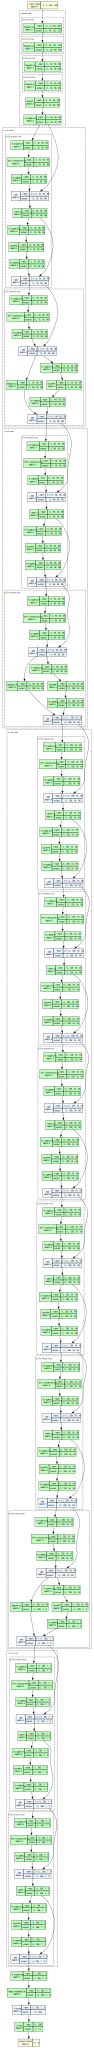

In [26]:
from torchview import draw_graph

model = cloformer_xxs(num_classes=3).to('cuda')

device = next(model.parameters()).device
print('model is on:', device)

batch_size = 1
model_graph = draw_graph(model, input_size=(batch_size, 3, 224, 224), expand_nested=True) # device='meta', 
model_graph.visual_graph

In [20]:
# TODO: herb images